# Universidade Federal de Juiz de Fora

## Aluno: Matheus Muniz Damasco

## Professor: Jairo Francisco de Souza

## Matéria: Tópicos Especiais em Aplicações da Computação


## Trabalho 2: Criando modelo de linguagem

**Objetivos**

Neste trabalho, nosso objetivo é que o aluno faça uma prática com treinamento de modelos de linguagem usando ferramentas já existentes. A ideia é que seja realizado um autoaprendizado, fomentando a discussão e o aprendizado através da experimentação.

**Organização**

Você irá trabalhar com o SRILM (http://www.speech.sri.com/projects/srilm/). Você deve fazer um relatório explicando os detalhes dos seus experimentos, com passo a passo de cada comando utilizado e análises de cada resultado, além de breve explicação dos métodos utilizados (métodos de descontos – smoothing –, backoffs, etc).

**Metodologia**

Para os experimentos, caberá a você determinar sua base de treinamento e sua base de testes. Recomenda-se o uso de bases grandes o suficiente para obter resultados satisfatórios. Existem bases
de treinamento disponíveis na web (Google ngram, Yahoo Labs ngram, bases como o Bosque, Floresta Sintactica e Amazonia para o português ou até mesmo textos da wikipedia que podem ser coletados via
Dbpedia).

**Experimentos a serem realizados**

Neste trabalho, espera-se que o aluno se debruce sobre as formas de treinamento, problemas que podem surgir e analisar os dados que estão sendo gerados (nem sempre números maiores/menores são bons, certo?).

**Minimamente, alguns tipos de análise devem ser feitas:**

• Usar métodos intrínsecos de avaliação: (1) melhorar perplexidade, adotar normalizações no texto, inserção ou remoção de textos na base de treinamento, etc para alcançar melhores valores de perplexidade; (2) contagem de ngrams singletons: quantidade de ngrams com contagem igual a 1 (quanto mais, tende a ser pior); (3) quantidade de OOVs.

• Avaliação empírica I: no seu conjunto de testes, coloque frases que estão corretamente escritas e frases que não fazem sentido. O objetivo do teu LM é ser capaz de classificar corretamente
frases bem escritas e frases mal escritas. Calcular acurácia do teu LM nessa base de testes.

• Avaliação empírica II: para avaliar o quão especializado teu LM está, utilize o método de visualização de Shannon para gerar frases com teu LM. Não sei se existe uma ferramenta própria pra isso. Imagino que você terá que criar um algoritmo para gerar essa visualização do teu LM (mas o método é bem simples). Permita que a frase seja iniciada aleatoriamente ou através de
um input de texto (primeiras palavras da frase).

• Realizar experimentos com teu modelo alterando as formas de generalização do modelo. Testar, necessariamente: (1) interpolação; (2) backoff; (3) diferentes métodos de suavização. Não se preocupe, essas ferramentas já lhe oferecem os métodos prontos. Mas é necessário entendê-los. Tente usar um stupid backoff, se possível. Explore os métodos de desconto disponíveis (K-ney, WB, etc).

• Extra: um bom LM é aquele onde o seu P(W) é o mais alto para uma frase W que faça sentido para o LM. Como você poderia usar um LM como classificador? Crie um pequeno script que permita classificar uma frase em, digamos, esporte x música ou poesia x prosa, etc.

# Instalação

Foi feita a instalação do [SRILM](http://www.speech.sri.com/projects/srilm/download.html) usando o WSL Ubuntu que foi instalado via Windows PowerShell.

# Dataset Escolhido:

Foi escolhido o Dataset 'árvores deitadas' da lista 'Parte do
CETEMPúblico' com o formato comprimido contido no [link](https://www.linguateca.pt/floresta/corpus.html#download).

# Bibliotecas Usadas

In [ ]:
import re
import nltk
import string
import random
import subprocess
import numpy as np

# Analise do Dataset



## 1. Verificar o Conteúdo do Corpus

Input:

```
head Bosque_CP_8.0.ad.txt
```

Output:

```
<ext n=1 sec=clt sem=92b>

<t>
<s>

SOURCE: CETEMPblico n=1 sec=clt sem=92b
CP1-1 Um revivalismo refrescante
A1
UTT:np
```



## 2. Limpar, Normalizar e Ajustar nosso Dataset



In [ ]:
# Verificar se o arquivo está disponível no caminho correto
!ls /content/

In [ ]:
# Baixar o tokenizer (apenas uma vez)
nltk.download('punkt')
# Definir a seed
random.seed(42)

In [ ]:
# Abrir o arquivo original para leitura
with open('/content/Bosque_CP_8.0.ad.txt', 'r', encoding='ISO-8859-1') as original_file:
    content = original_file.readlines()

# Remover tags <t>, <p> e <s>
content_cleaned = [re.sub(r'</?[stp]>', '', line) for line in content]

# Remover 'A1', 'A2' e 'A3' de cada linha
for i in range(1, 4):
    content_cleaned = [re.sub(fr'\bA{i}\b', '', line) for line in content_cleaned]

# Filtrar linhas que NÃO começam com palavras desnecessárias
content_cleaned = [
    line.strip() for line in content_cleaned
    if not line.startswith(('SOURCE', '=', 'UTT', 'STA', 'QUE', 'EXC'))
]

# Remover variações de <ext ...> e </ext>
content_cleaned = [re.sub(r'<\/?ext\b[^>]*>', '', line) for line in content_cleaned]

# Remover identificadores 'CPX-Y'
content_cleaned = [re.sub(r'^CP\d+-\d+\s*', '', line) for line in content_cleaned]

# Substituir « e » por strings vazias e limpar símbolos
content_cleaned = [line.replace('«', '').replace('»', '')
                  .replace('&&', '').replace('--', '').replace('X:x', '')
                  .replace('...', '').replace('-', ' ')
                  for line in content_cleaned]

# Remover linhas vazias
content_cleaned = [line for line in content_cleaned if line]
# Colocar o texto para minusculo
content_cleaned = [line.lower() for line in content_cleaned]
# Removendo a pontuação
content_cleaned = [line.translate(str.maketrans('', '', string.punctuation)) for line in content_cleaned]

# Tokenizar cada sentença e adicionar <s> e </s> corretamente
tokenized_sentences = [
    f"<s> {' '.join(nltk.word_tokenize(line))} </s>"
    for line in content_cleaned
]

# Remover duplicações de tags <s> e </s> (se existirem)
tokenized_sentences = [
    re.sub(r'<s>\s*</s>', '', line) for line in tokenized_sentences
]

# Salvar o corpus limpo e tokenizado em corpus_final.txt
with open('corpus_final.txt', 'w', encoding='utf-8') as new_file:
    new_file.write('\n'.join(tokenized_sentences) + '\n')

print("Arquivo copiado e limpo com sucesso para 'corpus_final.txt'.")

## 3. Dividir nosso Dataset Filtrado em Treino e Teste

In [ ]:
# Abrir o arquivo com o corpus completo
with open('corpus_final.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Definir a proporção de treino e teste
train_ratio = 0.7
train_size = int(len(lines) * train_ratio)

# Embaralhar as sentenças para garantir aleatoriedade
random.shuffle(lines)

# Dividir o corpus
train_data = lines[:train_size]
test_data = lines[train_size:]

# Salvar os dados de treino e teste em arquivos separados
with open('corpus_train.txt', 'w', encoding='utf-8') as train_file:
    train_file.writelines(train_data)

with open('corpus_test.txt', 'w', encoding='utf-8') as test_file:
    test_file.writelines(test_data)

print("Divisão do corpus em treino e teste concluída com sucesso.")

# SRILM



## Experimentos e Análises Intrínsecas:

### Unigrams

```
ngram-count -text corpus_train.txt -order 1 -write corpus_tr1.count
```

```
ngram-count -text corpus_train.txt -order 1 -addsmooth 0 -lm corpus_tr1.lm
```

#### Calculo de Perplexidade:
```
ngram -lm corpus_tr1.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -90987.42 ppl= 845.3804 ppl1= 1203.815
```

#### Contagem de N-grams Singletons:
```
ngram-count -read corpus_tr1.count -order 1 -write ngram_1gram.count
```
```
grep -P '\s+1$' ngram_1gram.count > ngram_singletons.count

```
Output:
```
...
ronaldoà	1
castigados	1
badaladas	1
jan	1
específico	1
geneterapia	1
niall	1
eternidade	1
alertaram	1
charme	1
iniciada	1
536	1
erguidas	1
indisponibilidade	1
pintora	1
congestionada	1
ordenado	1
fixação	1
incubadora	1
celestial	1
xiaoping	1
convivas	1
deserdados	1
levem	1
dera	1
ditadura	1
preenche	1
149	1
erguer	1
elevadíssima	1
matadouros	1
gravíssima	1
desmobilizado	1
descuidos	1
endereços	1
sacchi	1
nortenha	1
tornam	1
bénard	1
...
```

#### Contagem de OOVs (Out-of-Vocabulary Words):

```
ngram -lm corpus_tr1.lm -ppl corpus_test.txt -debug 2
```

Output:
```
...
<s> por si sós aos numerosos pequenos investidores que não estão incluídos nos 50 cabe uma fatia de 25 milhões de contos </s>
        p( por | <s> )  = [1gram] 0.006947123 [ -2.158195 ]
        p( si | por ...)        = [1gram] 0.0001565208 [ -3.805428 ]
        p( <unk> | si ...)      = [OOV] 0 [ -inf ]
        p( aos | <unk> ...)     = [1gram] 0.001480928 [ -2.829466 ]
        p( <unk> | aos ...)     = [OOV] 0 [ -inf ]
        p( pequenos | <unk> ...)        = [1gram] 0.0001324408 [ -3.877978 ]
        p( investidores | pequenos ...)         = [1gram] 7.224036e-05 [ -4.14122 ]
        p( que | investidores ...)      = [1gram] 0.02535636 [ -1.595913 ]
        p( não | que ...)       = [1gram] 0.00740464 [ -2.130496 ]
        p( estão | não ...)     = [1gram] 0.0006862842 [ -3.163496 ]
        p( incluídos | estão ...)       = [1gram] 1.204007e-05 [ -4.919371 ]
        p( nos | incluídos ...)         = [1gram] 0.001962534 [ -2.707183 ]
        p( 50 | nos ...)        = [1gram] 0.0001565208 [ -3.805428 ]
        p( cabe | 50 ...)       = [1gram] 3.612021e-05 [ -4.44225 ]
        p( uma | cabe ...)      = [1gram] 0.008741098 [ -2.058434 ]
        p( fatia | uma ...)     = [1gram] 1.204007e-05 [ -4.919371 ]
        p( de | fatia ...)      = [1gram] 0.04725731 [ -1.325531 ]
        p( 25 | de ...)         = [1gram] 0.0002769217 [ -3.557643 ]
        p( milhões | 25 ...)    = [1gram] 0.001011365 [ -2.995092 ]
        p( de | milhões ...)    = [1gram] 0.04725731 [ -1.325531 ]
        p( contos | de ...)     = [1gram] 0.001155846 [ -2.9371 ]
        p( </s> | contos ...)   = [1gram] 0.04350078 [ -1.361503 ]
1 sentences, 21 words, 2 OOVs
0 zeroprobs, logprob= -60.05663 ppl= 1006.541 ppl1= 1448.356

<s> p e porquê </s>
        p( p | <s> )    = [1gram] 0.0002769217 [ -3.557643 ]
        p( e | p ...)   = [1gram] 0.02418851 [ -1.616391 ]
        p( porquê | e ...)      = [1gram] 4.81603e-05 [ -4.317311 ]
        p( </s> | porquê ...)   = [1gram] 0.04350078 [ -1.361503 ]
1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -10.85285 ppl= 516.6684 ppl1= 4145.872

file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -90987.42 ppl= 845.3804 ppl1= 1203.815
```

### Bigrams

```
ngram-count -text corpus_train.txt -order 2 -write corpus_tr2.count
```

```
ngram-count -text corpus_train.txt -order 2 -addsmooth 0 -lm corpus_tr2.lm

```

#### Calculo de Perplexidade:
```
ngram -lm corpus_tr2.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
12929 zeroprobs, logprob= -34346.51 ppl= 77.93711 ppl1= 117.0024
```

#### Contagem de N-grams Singletons:
```
ngram-count -read corpus_tr2.count -order 2 -write ngram_2gram.count
```
```
grep -P '\s+1$' ngram_2gram.count > ngram_2singletons.count
```
Output:
```
...
dessexuados	1
dessexuados black	1
queima </s>	1
veiga francisco	1
veiga simão	1
candidatar pela	1
candidatar </s>	1
moleculares	1
moleculares e	1
inenarrável	1
inenarrável caos	1
detectavam	1
detectavam sismos	1
alugada	1
alugada pelo	1
reduzidas devido	1
reduzidas </s>	1
fados até	1
alentejo assegurando	1
alentejo e	1
sese	1
sese seko	1
tanger	1
tanger sublinhou	1
deferíveis	1
deferíveis situações	1
dirigido por	1
dirigido pelo	1
dirigido a	1
dirigido e	1
restará	1
restará um	1
câmaras da	1
siza </s>	1
relevância	1
relevância para	1
acentuada	1
acentuada da	1
garagem	1
garagem particular	1
...
```

#### Contagem de OOVs (Out-of-Vocabulary Words):

```
ngram -lm corpus_tr2.lm -ppl corpus_test.txt -debug 2
```

Output:
```
...
<s> fantasmas preocupantes </s>
        p( <unk> | <s> )        = [OOV] 0 [ -inf ]
        p( <unk> | <unk> ...)   = [OOV] 0 [ -inf ]
        p( </s> | <unk> ...)    = [1gram] 0.04350078 [ -1.361503 ]
1 sentences, 2 words, 2 OOVs
0 zeroprobs, logprob= -1.361503 ppl= 22.9881 ppl1= undefined

<s> por si sós aos numerosos pequenos investidores que não estão incluídos nos 50 cabe uma fatia de 25 milhões de contos </s>
        p( por | <s> )  = [2gram] 0.0102408 [ -1.989666 ]
        p( si | por ...)        = [2gram] 0.005199302 [ -2.284055 ]
        p( <unk> | si ...)      = [OOV] 0 [ -inf ]
        p( aos | <unk> ...)     = [1gram] 0.001480928 [ -2.829466 ]
        p( <unk> | aos ...)     = [OOV] 0 [ -inf ]
        p( pequenos | <unk> ...)        = [1gram] 0.0001324408 [ -3.877978 ]
        p( investidores | pequenos ...)         = [1gram] 0 [ -inf ]
        p( que | investidores ...)      = [1gram] 0 [ -inf ]
        p( não | que ...)       = [2gram] 0.02943967 [ -1.531067 ]
        p( estão | não ...)     = [2gram] 0.003252034 [ -2.487845 ]
        p( incluídos | estão ...)       = [1gram] 0 [ -inf ]
        p( nos | incluídos ...)         = [1gram] 0 [ -inf ]
        p( 50 | nos ...)        = [1gram] 0 [ -inf ]
        p( cabe | 50 ...)       = [1gram] 0 [ -inf ]
        p( uma | cabe ...)      = [1gram] 0 [ -inf ]
        p( fatia | uma ...)     = [1gram] 0 [ -inf ]
        p( de | fatia ...)      = [1gram] 0 [ -inf ]
        p( 25 | de ...)         = [1gram] 0 [ -inf ]
        p( milhões | 25 ...)    = [2gram] 0.2608695 [ -0.5835766 ]
        p( de | milhões ...)    = [2gram] 0.8333333 [ -0.07918125 ]
        p( contos | de ...)     = [2gram] 0.0155414 [ -1.80851 ]
        p( </s> | contos ...)   = [2gram] 0.3020833 [ -0.5198733 ]
1 sentences, 21 words, 2 OOVs
10 zeroprobs, logprob= -17.99122 ppl= 62.96828 ppl1= 99.77558

<s> p e porquê </s>
        p( p | <s> )    = [2gram] 0.005812338 [ -2.235649 ]
        p( e | p ...)   = [2gram] 0.04347825 [ -1.361728 ]
        p( porquê | e ...)      = [1gram] 0 [ -inf ]
        p( </s> | porquê ...)   = [2gram] 0.7500001 [ -0.1249387 ]
1 sentences, 3 words, 0 OOVs
1 zeroprobs, logprob= -3.722316 ppl= 17.40892 ppl1= 72.637

file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
12929 zeroprobs, logprob= -34346.51 ppl= 77.93711 ppl1= 117.0024
```

### Trigrams

```
ngram-count -text corpus_train.txt -order 3 -write corpus_tr3.count
```

```
ngram-count -text corpus_train.txt -order 3 -addsmooth 0 -lm corpus_tr3.lm
```

#### Calculo de Perplexidade:
```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
12929 zeroprobs, logprob= -33960.03 ppl= 74.20921 ppl1= 110.8977
```

#### Contagem de N-grams Singletons:
```
ngram-count -read corpus_tr3.count -order 3 -write ngram_3gram.count
```
```
grep -P '\s+1$' ngram_3gram.count > ngram_3singletons.count
```
Output:
```
...
identificação é	1
identificação é suficiente	1
identificação dos	1
identificação dos dois	1
identificação do	1
identificação do segundo	1
reeditado	1
reeditado numa	1
reeditado numa compilação	1
sócios vão	1
sócios vão poder	1
sócios franceses	1
sócios franceses do	1
sócios e	1
sócios e sete	1
sócios para	1
sócios para a	1
sócios quatro	1
sócios quatro disparos	1
sócios da	1
sócios da empresa	1
17h	1
17h </s>	1
coragem revelada	1
coragem revelada pelos	1
coragem de um	1
coragem de dar	1
coragem ideológica	1
coragem ideológica </s>	1
raffaelli	1
raffaelli o	1
raffaelli o mesmo	1
restany	1
restany e	1
restany e trabalhos	1
pensamos em	1
pensamos em mais	1
pensamos de	1
pensamos de forma	1
totally	1
totally kaos	1
totally kaos mais	1
erundina de	1
erundina de 58	1
erundina que	1
erundina que contrariou	1
15 metros	1
15 metros de	1
15 novas	1
15 novas experiências	1
15 de janeiro	1
15 de agosto	1
15 de julho	1
...
```

#### Contagem de OOVs (Out-of-Vocabulary Words):

```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt -debug 2
```

Output:
```
...
<s> por si sós aos numerosos pequenos investidores que não estão incluídos nos 50 cabe uma fatia de 25 milhões de contos </s>
        p( por | <s> )  = [2gram] 0.0102408 [ -1.989666 ]
        p( si | por ...)        = [2gram] 0.002173304 [ -2.662879 ]
        p( <unk> | si ...)      = [OOV] 0 [ -inf ]
        p( aos | <unk> ...)     = [1gram] 0.001480928 [ -2.829466 ]
        p( <unk> | aos ...)     = [OOV] 0 [ -inf ]
        p( pequenos | <unk> ...)        = [1gram] 0.0001324408 [ -3.877978 ]
        p( investidores | pequenos ...)         = [1gram] 0 [ -inf ]
        p( que | investidores ...)      = [1gram] 0 [ -inf ]
        p( não | que ...)       = [2gram] 0.02943967 [ -1.531067 ]
        p( estão | não ...)     = [2gram] 0.00270508 [ -2.56782 ]
        p( incluídos | estão ...)       = [1gram] 0 [ -inf ]
        p( nos | incluídos ...)         = [1gram] 0 [ -inf ]
        p( 50 | nos ...)        = [1gram] 0 [ -inf ]
        p( cabe | 50 ...)       = [1gram] 0 [ -inf ]
        p( uma | cabe ...)      = [1gram] 0 [ -inf ]
        p( fatia | uma ...)     = [1gram] 0 [ -inf ]
        p( de | fatia ...)      = [1gram] 0 [ -inf ]
        p( 25 | de ...)         = [1gram] 0 [ -inf ]
        p( milhões | 25 ...)    = [2gram] 0.2608695 [ -0.5835766 ]
        p( de | milhões ...)    = [3gram] 0.8333333 [ -0.07918125 ]
        p( contos | de ...)     = [3gram] 0.7285714 [ -0.1375279 ]
        p( </s> | contos ...)   = [3gram] 0.2786885 [ -0.5548809 ]
1 sentences, 21 words, 2 OOVs
10 zeroprobs, logprob= -16.81404 ppl= 48.01803 ppl1= 73.82901

<s> p e porquê </s>
        p( p | <s> )    = [2gram] 0.005812338 [ -2.235649 ]
        p( e | p ...)   = [2gram] 0.04260651 [ -1.370524 ]
        p( porquê | e ...)      = [1gram] 0 [ -inf ]
        p( </s> | porquê ...)   = [2gram] 0.7500001 [ -0.1249387 ]
1 sentences, 3 words, 0 OOVs
1 zeroprobs, logprob= -3.731112 ppl= 17.52685 ppl1= 73.37632

file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
12929 zeroprobs, logprob= -33960.03 ppl= 74.20921 ppl1= 110.8977
```

## Avaliação Empírica I:

### Algumas Frases Incorretas e Algumas sem sentidos achadas no Conjunto de Teste

1. 'antes de mes parents e muito antes dos livros sida '
2. 'foi sol de pouca dura '
3. 'o beira mar a outra equipa da cidade de aveiro procedeu também no início desta semana à substituição do norte americano mike smith pelo seu compatriota deshon washington '
4. 'este assunto aliás foi também discutido na ccpm que quinta feira efectuou a sua 27ª plenária após um interregno de 20 dias'

### Calculo da Acurácia do LM:



In [ ]:
# Lista para armazenar as perplexidades
perplexities = []

# Ler as perplexidades do arquivo ppl_output.txt
with open('ppl_output3.txt', 'r') as f:
    for line in f:
        if 'ppl=' in line:
            # Tente extrair o valor da perplexidade, ignorando valores 'undefined'
            try:
                perplexity = float(line.split('ppl=')[1].split()[0])
                perplexities.append(perplexity)
            except ValueError:
                # Ignorar se houver 'undefined'
                continue

# Verificar se temos perplexidades válidas
if perplexities:
    # Calcular a mediana das perplexidades
    mean_perplexity = np.mean(perplexities)

    # Classificar as frases: 1 (correta) se perplexidade < media, 0 (incorreta) se perplexidade ≥ media
    predictions = [1 if p < mean_perplexity else 0 for p in perplexities]

    # Calcular a "acurácia" com base na divisão pela mediana
    accuracy = sum(predictions) / len(predictions)

    print(f"Perplexidades válidas: {len(perplexities)}")
    print(f"Média das perplexidades: {mean_perplexity}")
    print(f"Acurácia (baseada na média): {accuracy}")
else:
    print("Nenhuma perplexidade válida foi encontrada.")

A saída indica que:

* Nos temos 1544 frases no conjunto de testes com perplexidades válidas.
* A média das perplexidades é 255.013, o que é um ponto de referência para a nossa classificação.
* Com base na média das perplexidades, sua acurácia foi calculada como 0.9307. Isso significa que de acordo com a minha suposição, cerca de 93% das frases têm perplexidades abaixo da média (sendo classificadas como "corretas").

( Acredito que apos usar esse metodo e analisando algumas sentenças geradas cheguei a conclusão que ele não consegue apresentar uma boa noção do nosso modelo por que a média pode ser influenciada facilmente pelos Outliers. )

## Avaliação empírica II:




### Shannon Visualization Method:

Os passos para o metodo de visualização de Shannon são:

▪ Escolha um bigrama aleatório $(<s>, w)$ de acordo com sua probabilidade

▪ Agora escolha um bigrama aleatório $(w, x)$ de acordo com sua probabilidade

▪ E assim por diante até escolhermos $</s>$

▪ Então, junte as palavras para formar a frase

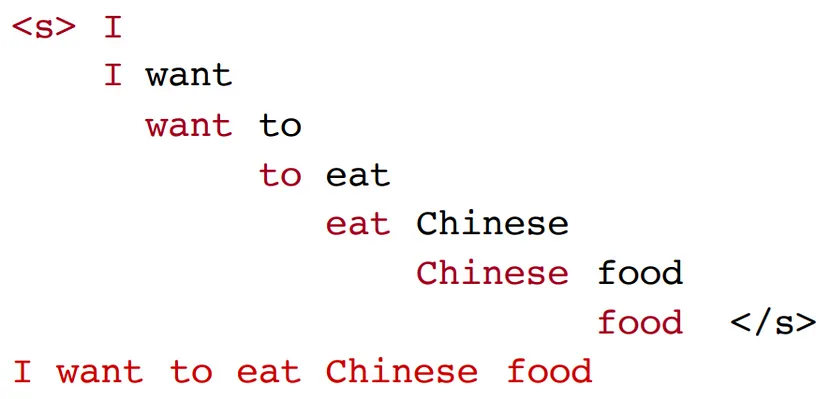


Modelo:
```
ngram-count -read corpus_tr2.count -order 2 -addsmooth 0 -lm corpus_tr2.lm
```



Geração de 10 frases:

```
ngram -lm corpus_tr2.lm -gen 10
```



In [ ]:
def gerar_frase_shannon(modelo_lm, input_text=None):
    if input_text:
        frase = input_text.split()
    else:
        frase = ['<s>']

    while True:
        comando = [
            'ngram',
            '-lm', modelo_lm,
            '-ppl', '-',
            '-debug', '2'
        ]
        processo = subprocess.Popen(comando, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        stdout, _ = processo.communicate(input=" ".join(frase) + " \n")
        palavras_previsao = []
        for linha in stdout.split('\n'):
            match = re.search(r'p\(\s*(\w+)', linha)
            if match:
                palavra = match.group(1)
                palavras_previsao.append(palavra)

        if not palavras_previsao:
            print("Nenhuma palavra prevista, encerrando.")
            break
        proxima_palavra = random.choice(palavras_previsao)
        frase.append(proxima_palavra)
        if proxima_palavra == '</s>':
            break

    return " ".join(frase)

modelo_lm = 'corpus_tr2.lm'
input_text = input("Digite as primeiras palavras da frase (ou deixe em branco para aleatório): ").strip()
if input_text:
    frase_gerada = gerar_frase_shannon(modelo_lm, input_text)
else:
    frase_gerada = gerar_frase_shannon(modelo_lm)

print(f"A frase gerada é: {frase_gerada}")

## Experimentos:

### Interpolação:

Para usarmos a interpolação só precisamos adicionar -interpolate na nossa função. Interpolação é uma técnica comum usada em modelos de n-gramas para calcular a probabilidade de uma palavra combinando probabilidades de diferentes ordens de n-gramas (unigrama, bigrama, trigramas, etc.). O conceito básico é criar uma nova probabilidade ponderando e combinando as probabilidades dos diferentes n-gramas.

Inputs:
```
ngram-count -order 3 -text corpus_train.txt -lm corpus_tr3.lm -addsmooth 1 -interpolate
```
```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -100908.8 ppl= 1762.879 ppl1= 2608.968
```



### Backoff:

Quando usamos o 'Witten-Bell discounting' sem a opção -interpolate, temos a versão com backoff, que é implementada tomando $f(a_z)$ como sendo o mesmo que o $g(a_z)$ interpolado.

Inputs:
```
ngram-count -order 3 -text corpus_train.txt -lm corpus_tr3.lm -wbdiscount
```
```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -83467.25 ppl= 484.3167 ppl1= 669.807
```




### Suavização:

#### 1. Kneser-Ney Discounting (KND):
Kneser-Ney Discounting é um dos métodos de suavização mais eficazes e amplamente utilizados em modelos de linguagem. Sua principal característica é melhorar a suavização em n-gramas raros, tornando o modelo mais robusto para palavras e combinações de palavras pouco frequentes.


Inputs:
```
ngram-count -order 3 -text corpus_train.txt -lm corpus_tr3.lm -kndiscount
```
```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -83006.54 ppl= 468.0677 ppl1= 646.1771
```
#### 2. Ristad's Natural Discounting Law:
Ristad’s Natural Discounting Law é um método de suavização proposto por Ristad que tenta modelar a suavização com base em princípios naturais de frequência e probabilidade. A suavização "N-Discount" redistribui a probabilidade de maneira a ajustar mais suavemente os n-gramas com base em uma função de probabilidade que se assemelha à forma como os humanos processam e lidam com frequências de palavras raras e frequentes.

Inputs:
```
ngram-count -order 3 -text corpus_train.txt -lm corpus_tr3.lm -ndiscount
```
```
ngram -lm corpus_tr3.lm -ppl corpus_test.txt
```
Output:
```
file corpus_test.txt: 1549 sentences, 33457 words, 3921 OOVs
0 zeroprobs, logprob= -82878.51 ppl= 463.6495 ppl1= 639.7595
```
